In [1]:
import numpy as np
np.zeros(5).shape

(5,)

In [4]:
import numpy as np
import scipy
from numba import njit, vectorize, int32, int64, float32, float64
import csv
with open("pl_100.txt", "r") as datafile:
    readfile = csv.reader(datafile)
    data = []
    for row in readfile:
        str_row = row[0].split()
        int_row = []
        for i in str_row:
            int_row.append(float(i))
        data.append(int_row)
   
    N = int(data[0][0])
    t_max = data[0][1]
    t_delta = data[0][2]/100
    m= np.array(data[1:N+1])
    r = np.array(data[N+1:2*N+1])
    v = np.array(data[2*N+1:])

m = m/sum(m)
R = sum(m*r)
RV = sum(m*v)
r_transformed = r-R
v_transformed = v-RV
delta_t = t_delta



In [5]:
# physical functions
@njit
def acc_vec(pos):
    a = np.zeros((N,3))
    for i in range(N):
        store = np.zeros((N,3))
        for j in range(N):
            if i!=j:
                store[j,:] = (m[j,0]*(pos[j,:]-pos[i,:])/np.sum((pos[j,:]-pos[i,:])**2,axis=0)**(3/2))
        a[i,:] =np.sum(store,axis=0)
    return a, a

    
@njit
def dot(a,b):
    for i in range(3):
        return (a[0]*b[0]+a[1]*b[1]+a[2]*b[2])
# @njit
# def acc_der(pos,vel):
#     a = np.zeros((N,3))
#     for i in range(0,N):
#         store = np.zeros((N,3))
#         for j in range(0,N):
#             if i!=j:
#                 store[j,:] = m[j,0]*((vel[j,:]-vel[i,:])/dot(pos[j,:]-pos[i,:],pos[j,:]-pos[i,:])**(3/2)-3*dot(vel[j,:]-vel[i,:],pos[j,:]-pos[i,:])*(pos[j,:]-pos[i,:])/dot(pos[j,:]-pos[i,:],pos[j,:]-pos[i,:])**(5/2))
#         a[i,:] = np.sum(store,axis=0)
#     return a
@njit 
def acc_der(pos,vel):
    a = np.zeros((N,3))
    for i in range(0,N):
        store = np.zeros((N,3))
        for j in range(0,N):
            if i!=j:
                store[j,:] = (m[j,0]*((vel[j,:]-vel[i,:])/(np.sum((pos[j,:]-pos[i,:])**2)**(3/2))-3*np.sum((vel[j,:]-vel[i,:])*(pos[j,:]-pos[i,:]))*(pos[j,:]-pos[i,:])/(np.sum((pos[j,:]-pos[i,:])**2)**(5/2))))
        a[i,:] = np.sum(store,axis=0)
    return a 
@njit
def eng(pos,vel,k):
    v_sq= np.sum(vel*vel,axis=1)
    T= np.sum(m[:,0]*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        
        norm = np.sqrt(np.sum((pos-pos[n])**2,axis=1))
        norm[n]=1
        V[n]= np.sum(m[:,0]*m[n,0]*1/norm,axis=0)/2-m[n,0]*m[n,0]/2

    V = np.sum(V)
    return T-V
@njit
def total_angular_momentum(pos,vel):
    cross = np.zeros((N,3))
    for n in range(N):
        cross[n,0] = pos[n,1]*vel[n,2]-pos[n,2]*vel[n,1]
        cross[n,1] = pos[n,2]*vel[n,0]-pos[n,0]*vel[n,2]
        cross[n,2] = pos[n,0]*vel[n,1]-pos[n,1]*vel[n,0]
        cross[n,:] *= m[n,0]
    return np.sum(cross,axis=0)

@njit
def total_momentum(vel):
    mom = np.zeros((N,3))
    for n in range(N):
        mom[n,:] = m[n,0]*vel[n,:]
    return np.sum(mom,axis=0)

@njit 
def cross(a,b):
    c = np.zeros(3)
    c[0] = a[1]*b[2]-a[2]*b[1]
    c[1] = a[2]*b[0]-a[0]*b[2]
    c[2] = a[0]*b[1]-a[1]*b[0]
    return c

@njit
def j_vec(pos,vel):
    r = pos[1,:]-pos[0,:]
    v = vel[1,:]-vel[0,:]
    return cross(r,v), r, v

@njit
def runge_lenz(j,r,v):
    return cross(v,j)-r/np.sqrt(np.sum(r**2))

@njit
def a_gha(j,e):
  return np.sum(j**2)/(1-np.sum(e**2))

@njit
def fac(i):
    result = 1
    for x in range(2,i+1):
        result = result*x
    return result
@njit
def test(func1,func2,v,numb):
    return func1(v)/func2(numb)

j, relr, relv = j_vec(r,v)
e = runge_lenz(j,relr,relv)
a_gha(j,e)

7.371802395112076

In [7]:
# integrators
zero = np.zeros((N,3))

@njit
def euler(pos,vel,tdelt):
    a,rij_betrag = acc_vec(pos)
    dta = acc_der(pos,vel)
    vel1 = vel+a*tdelt
    pos = pos+vel*tdelt
    return pos, vel1, a, dta, rij_betrag
@njit  
def euler_cromer(pos,vel,tdelt):
    a,rij_betrag = acc_vec(pos)
    dta = acc_der(pos,vel)
    vel2= vel+a*tdelt
    pos2 = pos+ vel2*tdelt
    return pos2, vel2, a, dta, rij_betrag
@njit

def velo_verlet(pos,vel,a1,tdelt):
    
    pos = pos + vel*tdelt+a1*tdelt**2/2
    a2,rij_betrag = acc_vec(pos)
    vel = vel +(a1+a2)*tdelt/2
    return pos, vel, a2, rij_betrag
 
@njit
def kick_drift(pos,vel,a1,tdelt):
    dta = acc_der(pos,vel)
    vel1 = vel+a1*tdelt/2
    pos = pos +vel1*tdelt
    a2,rij_betrag = acc_vec(pos)
    vel = vel1 + a2*tdelt/2
    return pos, vel, a2, dta, rij_betrag
 
# # Interpolationsfunktion benutzt in Hermite-integratoren
@njit 
def interp(Ord,tdelt):
    store = np.zeros((3,N,3))
    # for i in range(0,3):
    #     store[i,:,:]= Ord[i]*tdelt**i/fac(i)
    return sum(store)


 

@njit
def hermite(pos,vel,tdelt):
    a,rij_betrag = acc_vec(pos)
    dta = acc_der(pos,vel)
    vp= vel+a*tdelt+dta*tdelt*tdelt/2
    rp = pos+vel*tdelt+a*tdelt**2/2+dta*tdelt**3/6
    ap,waste = acc_vec(rp)
    dtap = acc_der(rp,vp)
    dt2a = -6*(a-ap)/tdelt**2-2*(2*dta+dtap)/tdelt
    dt3a = 12*(a-ap)/tdelt**3+6*(dta+dtap)/tdelt**2
    rc = rp+1/24*dt2a*tdelt**4+1/120*dt3a*tdelt**5
    vc = vp+1/6*dt2a*tdelt**3+1/24*dt3a*tdelt**4
    return rc, vc, a, dta, dt2a, dt3a, rij_betrag

@njit
def hermite_integrator(pos,vel,a,ap,dta,dtap):
    vc = vel + (a+ap)*delta_t/2+(dtap-dta)*delta_t**2/12
    rc = pos + (vc+vel)*delta_t/2+(ap-a)*delta_t**2/12
    ac,rij_betrag = acc_vec(rc)
    dtac = acc_der(rc,vc)
    return rc, vc, ac, dtac, rij_betrag
 
@njit
def iterated_hermite(pos,vel,a, dta,tdelt):
    vp= vel+a*tdelt+dta*tdelt*tdelt/2
    rp = pos+vel*tdelt+a*tdelt**2/2+dta*tdelt**3/6
    ap, waste = acc_vec(rp)
    dtap = acc_der(rp,vp)
    rc = pos
    vc = vel
    dt2a = -6*(a-ap)/tdelt**2-2*(2*dta+dtap)/tdelt
    dt3a = 12*(a-ap)/tdelt**3+6*(dta+dtap)/tdelt**2
    for i  in range(0,2):
        rc, vc, ap, dtap, rij_betrag = hermite_integrator(rc,vc,a,ap,dta,dtap)
    return rc, vc, ap, dtap, dt2a, dt3a, rij_betrag

@njit 
def heun(pos,vel,tdelt):
    a, rij_betrag = acc_vec(pos)
    dta = acc_der(pos,vel)
    v1 = a*tdelt
    r1 = vel*tdelt
    v2 = acc_vec(pos+r1)[0]*tdelt
    r2 = (vel+v2)*tdelt
    v_iter=vel+(v1+v2)/2
    r_iter = pos +(r1+r2)/2
    return r_iter,v_iter,a, dta, rij_betrag
 
@njit
def rk4(pos,vel,tdelt):
    a, rij_betrag = acc_vec(pos)
    dta = acc_der(pos,vel)
    v1 = a*tdelt
    r1= vel*tdelt
    v2  = acc_vec(pos+r1/2)[0]*tdelt
    r2 = (vel+v1/2)*tdelt
    v3 = acc_vec(pos+r2/2)[0]*tdelt
    r3 = (vel+v2/2)*tdelt
    v4 = acc_vec(pos+r3)[0]*tdelt
    r4 = (vel+v3)*tdelt
    r_iter = pos +(r1+r4)/6+(r2+r3)/3
    v_iter = vel + (v1+v4)/6+(v2+v3)/3
    return r_iter, v_iter, a, dta, rij_betrag
 
 
# absolute values
@njit
def absol(x):
    return np.sqrt(np.sum(x*x,axis=1))

@njit 
def time_delta(a_iter,dta_iter):
    dta_abs = absol(dta_iter)
    for i in range(N):
        if dta_abs[i]==0:
            dta_abs[i]=0.0001    
    return min(absol(a_iter)/dta_abs)
 
@njit 
def time_delta_hermite(a,dta,dt2a,dt3a):
   return min((absol(a)*absol(dt2a)+absol(dta)**2)/(absol(dta)*absol(dt3a)+absol(dt2a)**2))**(1/2)*t_delta


In [21]:
rc, vc, a, dta, dt2a, dt3a, rij_betrag=hermite(r,v,delta_t)
type(time_delta_hermite(a,dta,dt2a,dt3a))
min((1,1))

1

0

In [8]:
@njit
def iterator(integrator_abrv,steps,block_size):
    if (N!=0):

        t_sum = 0
        delta_t=t_delta
        r_iter= r_transformed
        v_iter= v_transformed
        course_r = np.zeros((steps//block_size+1,N,3))
        course_v = np.zeros((steps//block_size+1,N,3))
        course_t = np.zeros((steps//block_size+1))
        course_r[0,:,:]=r_iter
        course_v[0,:,:]=v_iter
        course_t[0]= 0
       
        a_iter,rij_betrag = acc_vec(r_iter)
        
        dta_iter = acc_der(r_iter,v_iter)

        if (integrator_abrv=='hermite'):
            integrator = hermite
            
            for zähler in range(steps):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a_iter,dta_iter,dt2a,dt3a,rij_betrag = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta_hermite(a_iter,dta_iter,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)

        elif integrator_abrv=='iterated_hermite':
            integrator = iterated_hermite
          
            for zähler in range(0,steps):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a,dta,dt2a,dt3a, rij_betrag = integrator(r_iter,v_iter,a_iter,dta_iter,delta_t)
                delta_t = time_delta_hermite(a_iter,dta_iter,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)
        elif integrator_abrv == 'velo_verlet':
            integrator = velo_verlet
            
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,rij_betrag = integrator(r_iter,v_iter,a_iter,delta_t)
            
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)


        elif integrator_abrv == 'kick_drift':
            integrator = kick_drift
            
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,dta_iter, rij_betrag = integrator(r_iter,v_iter,a_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if (delta_t<t_delta-0.3*t_delta):
                    delta_t=t_delta-0.3*t_delta
                elif (t_delta+10*t_delta<delta_t):
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)
        else:
            if integrator_abrv == 'euler':
                integrator = euler
            elif integrator_abrv == 'euler_cromer':
                integrator = euler_cromer
            elif integrator_abrv == 'heun':
                integrator = heun
            elif integrator_abrv == 'rk4':
                integrator = rk4
            
            
            
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter, dta_iter,rij_betrag = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if delta_t<t_delta-0.3*t_delta:
                    delta_t=t_delta-0.3*t_delta
                elif t_delta+10*t_delta<delta_t:
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%5000==0:
                    print(zähler)
    return course_t, course_r, course_v


In [56]:
# @njit
def iterator(integrator_abrv,steps,block_size):
    if (N==2):
        if (integrator_abrv=='hermite'):
            integrator = hermite
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            dta = acc_der(r_iter,v_iter)
            print(int(t_max/t_delta*5))
            for zähler in range(0,steps-14):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a,dta,dt2a,dt3a,rij_betrag = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta_hermite(a,dta,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)

        elif integrator_abrv=='iterated_hermite':
            integrator = iterated_hermite
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            dta = acc_der(r_iter,v_iter)
            print(int(t_max/t_delta*5))
            for zähler in range(0,steps-14):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a,dta,dt2a,dt3a, rij_betrag = integrator(r_iter,v_iter,a,dta,delta_t)
                delta_t = time_delta_hermite(a,dta,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)
        elif integrator_abrv == 'velo_verlet':
            integrator = velo_verlet
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            # steps = 3000000
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a_iter,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,rij_betrag = integrator(r_iter,v_iter,a_iter,delta_t)
            
                if zähler%block_size==0:
                    
                    c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)


        elif integrator_abrv == 'kick_drift':
            integrator = kick_drift
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            # steps = 300000
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a_iter,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,dta_iter, rij_betrag = integrator(r_iter,v_iter,a_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if (delta_t<t_delta-0.3*t_delta):
                    delta_t=t_delta-0.3*t_delta
                elif (t_delta+10*t_delta<delta_t):
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)
        else:
            if integrator_abrv == 'euler':
                integrator = euler
            elif integrator_abrv == 'euler_cromer':
                integrator = euler_cromer
            elif integrator_abrv == 'heun':
                integrator = heun
            elif integrator_abrv == 'rk4':
                integrator = rk4
            
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            # steps = 300000
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            
            for zähler in range(0,steps-14):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter, dta_iter,rij_betrag = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if delta_t<t_delta-0.3*t_delta:
                    delta_t=t_delta-0.3*t_delta
                elif t_delta+10*t_delta<delta_t:
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%5000==0:
                    print(zähler)
    else:
        if (integrator_abrv=='hermite'):
            integrator = hermite
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            dta = acc_der(r_iter,v_iter)
            print(int(t_max/t_delta*5))
            for zähler in range(0,steps-14):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a,dta,dt2a,dt3a, rij_betrag = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta_hermite(a,dta,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    # c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    # c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    # c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)

        elif integrator_abrv=='iterated_hermite':
            integrator = iterated_hermite
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            dta = acc_der(r_iter,v_iter)
            print(int(t_max/t_delta*5))
            for zähler in range(0,steps-14):
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter,v_iter,a,dta,dt2a,dt3a, rij_betrag = integrator(r_iter,v_iter,a,dta,delta_t)
                delta_t = time_delta_hermite(a,dta,dt2a,dt3a)
                if (delta_t<abs(t_delta-0.3*t_delta)):
                    delta_t=abs(t_delta-0.3*t_delta)
                elif (t_delta+t_delta<delta_t):
                    delta_t=t_delta+t_delta
                if zähler%block_size==0:
                    
                    # c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    # c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    # c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                
                if zähler%100000 == 0:
                    print(zähler)
        elif integrator_abrv == 'velo_verlet':
            integrator = velo_verlet
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            # steps = 3000000
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a_iter,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,rij_betrag = integrator(r_iter,v_iter,a_iter,delta_t)
            
                if zähler%block_size==0:
                    
                    # c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    # c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    # c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)


        elif integrator_abrv == 'kick_drift':
            integrator = kick_drift
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            # steps = 300000
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a_iter,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            for zähler in range(0,steps):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter,dta_iter, rij_betrag = integrator(r_iter,v_iter,a_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if (delta_t<t_delta-0.3*t_delta):
                    delta_t=t_delta-0.3*t_delta
                elif (t_delta+10*t_delta<delta_t):
                    delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    # c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    # c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    # c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%50000==0:
                    print(zähler)
        else:
            if integrator_abrv == 'euler':
                integrator = euler
            elif integrator_abrv == 'euler_cromer':
                integrator = euler_cromer
            elif integrator_abrv == 'heun':
                integrator = heun
            elif integrator_abrv == 'rk4':
                integrator = rk4
            else:
                print("integrator not recognized.")
                exit()
            
            t_sum = 0
            delta_t=t_delta
            t_max = 62
            r_iter= r_transformed
            v_iter= v_transformed
            # steps = 300000
            course_r = np.zeros((steps//block_size,N,3))
            course_v = np.zeros((steps//block_size,N,3))
            course_t = np.zeros((steps//block_size))
            course_r[0,:,:]=r_iter
            course_v[0,:,:]=v_iter
            course_t[0]= 0
            c_energy = np.zeros((steps//block_size))
            c_totm = np.zeros((steps//block_size,3))
            c_tot_angm = np.zeros((steps//block_size,3))
            c_tot_angm[0,:] = total_angular_momentum(r_iter,v_iter)
            c_totm[0,:] = total_momentum(v_iter)
            a,rij_betrag = acc_vec(r_iter)
            c_energy[0]= eng(r_iter,v_iter,rij_betrag)
            
            for zähler in range(0,steps-14):
            
                t_sum= t_sum+delta_t
                if zähler%block_size==0:
                    course_t[zähler//block_size] =t_sum
                r_iter, v_iter, a_iter, dta_iter,rij_betrag = integrator(r_iter,v_iter,delta_t)
                delta_t = time_delta(a_iter,dta_iter)
                if delta_t<t_delta-0.3*t_delta:
                    delta_t=t_delta-0.3*t_delta
                elif t_delta+10*t_delta<delta_t:
                   delta_t=t_delta+10*t_delta
                if zähler%block_size==0:
                    
                    # c_energy[zähler//block_size]= eng(r_iter,v_iter,rij_betrag)
                    # c_tot_angm[zähler//block_size,:] = total_angular_momentum(r_iter,v_iter)
                    # c_totm[zähler//block_size,:] = total_momentum(v_iter)
                    course_r[zähler//block_size,:,:] =r_iter
                    course_v[zähler//block_size,:,:] =v_iter
                if zähler%5000==0:
                    print(zähler)
    return t_sum, course_r, course_v, course_t, c_energy, c_totm, c_tot_angm #, c_j, c_rulenz

1e-05

In [15]:
steps = 50000*2
block_size = 1
course_t, course_r, course_v= iterator('hermite',steps,block_size)

0


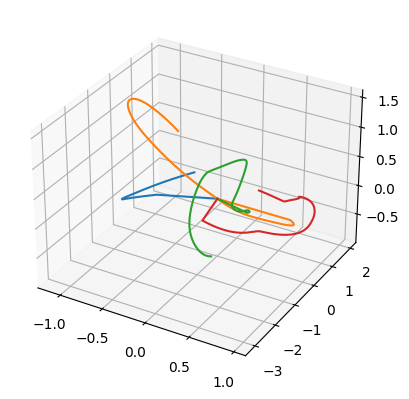

In [16]:
import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(projection='3d')
import time
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_color('black')
# ax.xaxis.label.set_color('black')
# ax.yaxis.label.set_color('black')
# ax.zaxis.label.set_color('black')
# ax.tick_params(axis='y', colors='black',labelrotation=40)
# ax.tick_params(axis='x', colors='black')#,labelrotation=40)

# ax.tick_params(axis='z', colors='black')
# ax.set_facecolor("white")
# ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
# ax.view_init(20,25,0)

for i in range(0,4):
    ax.plot(course_r[:,i,0],course_r[:,i,1],course_r[:,i,2])
    
    
    
plt.show()

0.0


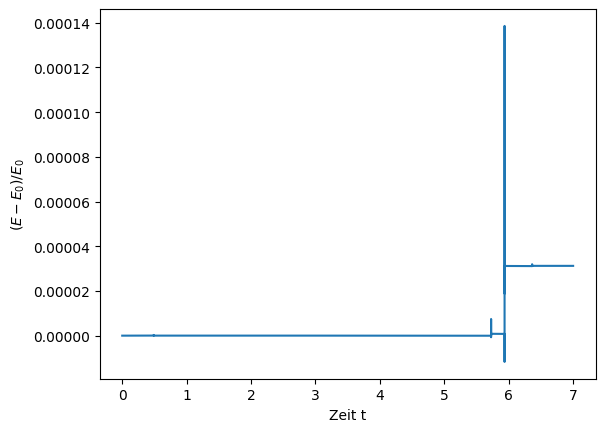

In [18]:
import matplotlib.pyplot as plt
@njit
def eng(pos,vel,k):
    v_sq= np.sum(vel*vel,axis=1)
    T= np.sum(m[:,0]*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        
        norm = np.sqrt(np.sum((pos-pos[n])**2,axis=1))
        norm[n]=1
        V[n]= np.sum(m[:,0]*m[n,0]*1/norm,axis=0)/2-m[n,0]*m[n,0]/2

    V = np.sum(V)
    return T-V
c_energy= np.zeros(course_r.shape[0])
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)
print(course_t[-1])
fig, ax = plt.subplots(1,1)
ax.plot(course_t,(c_energy-c_energy[0])/c_energy[0])
ax.set_xlabel("Zeit t")
ax.set_ylabel(r"$(E-E_0)/E_0$")
plt.show()

In [19]:
with open("100b_hermite2.txt","w") as file:
    for i in range(steps//block_size):
        file.write("{:.6e}\t".format(course_t[i]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_r[i,j,l]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_v[i,j,l]))
        
    

OSError: [Errno 28] No space left on device

In [51]:

c_j = np.zeros((steps//block_size+1,3))
c_rulenz = np.zeros((steps//block_size+1,3))
c_a_bha = np.zeros((steps//block_size+1))
c_rel_r = np.zeros((steps//block_size+1,3))
c_rel_v =np.zeros((steps//block_size+1,3))
for i in range(steps//block_size+1):
    c_j[i,:], c_rel_r[i,:], c_rel_v[i,:] = j_vec(course_r[i,:],course_v[i,:])
    c_rulenz[i,:] = runge_lenz(c_j[i,:],c_rel_r[i,:], c_rel_v[i,:])
    c_a_bha[i] = a_gha(c_j[i,:],c_rulenz[i,:])

In [260]:
print(2*np.pi*100)
# course_t[57150]
c_rulenz[0,0]= 1/10**10

628.3185307179587


In [13]:
import pandas as pd
data = pd.read_csv("100b_euler_cromer.txt",header=None,sep='\t')
data = data.to_numpy()

In [18]:
print(data.shape)

(1, 360601)


In [17]:

course_r = np.zeros((data.shape[0],100,3))
course_v = np.zeros((data.shape[0],100,3))
course_t = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    course_t[i]=data[i,0]
    for j in range(3):
        course_r[i,:,j] = data[i,1+j:301:3]
        course_v[i,:,j] = data[i,301+j::3]



ValueError: could not broadcast input array from shape (120100,) into shape (100,)

In [ ]:
import matplotlib.pyplot as plt
@njit
def eng(pos,vel,k):
    v_sq= np.sum(vel*vel,axis=1)
    T= np.sum(m[:,0]*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        
        norm = np.sqrt(np.sum((pos-pos[n])**2,axis=1))
        norm[n]=1
        V[n]= np.sum(m[:,0]*m[n,0]*1/norm,axis=0)/2-m[n,0]*m[n,0]/2

    V = np.sum(V)
    return T-V
c_energy= np.zeros(course_r.shape[0])
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)
print(course_t[-1])
fig, ax = plt.subplots(1,1)
ax.plot(course_t,(c_energy-c_energy[0])/c_energy[0])
ax.set_xlabel("Zeit t")
ax.set_ylabel(r"$(E-E_0)/E_0$")
plt.show()

In [29]:
with open("2b_hermite_const_time.txt","w") as file:
    file.write("course_t\tcourse_r[0,x]\tcourse_r[0,y]\tcourse_r[0,z]\tcourse_r[1,x]\tcourse_r[1,y]\tcourse_r[1,z]\tcourse_v[0,x]\tcourse_v[0,y]\tcourse_v[0,z]\tcourse_v[1,x]\tcourse_v[1,y]\tcourse_v[1,z]\tc_energy\tc_totm[x]\tc_totm[y]\tc_totm[z]\tc_tot_angm[x]\tc_tot_angm[y]\tc_tot_angm[z]\tc_j[x]\tc_j[y]\tc_j[z]\tc_rulenz[x]\tc_rulenz[y]\tc_rulenz[z]\tc_a_bha\n")
    for i in range(steps//block_size):
        file.write("{:.6e}\t".format(course_t[i]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_r[i,j,l]))
        for j in range(N):
            for l in range(3):
                file.write("{:.6e}\t".format(course_v[i,j,l]))
        file.write("{:.6e}\t".format(c_energy[i]))
        for j in range(3):
            file.write("{:.6e}\t".format(c_totm[i,j]))
        for j in range(3):
            file.write("{:.6e}\t".format(c_tot_angm[i,j]))
        for j in range(3):
            file.write("{:.6e}\t".format(c_j[i,j]))
        for j in range(3):
            file.write("{:.6e}\t".format(c_rulenz[i,j]))
        file.write("{:.6e}\n".format(c_a_bha[i]))
    


In [ ]:
import pandas as pd
data = pd.read_csv("2b_hermite.txt",sep='\t')
print(data.head())

course_r0 = data[["course_r[0,x]","course_r[0,y]","course_r[0,z]"]].to_numpy()
course_r1 = data[["course_r[1,x]","course_r[1,y]","course_r[1,z]"]].to_numpy()
course_v0 = data[["course_v[0,x]","course_v[0,y]","course_v[0,z]"]].to_numpy()
course_v1 = data[["course_v[1,x]","course_v[1,y]","course_v[1,z]"]].to_numpy()
course_r = np.zeros((course_r1.shape[0],2,3))
course_v = np.zeros((course_r1.shape[0],2,3))
course_r[:,0,:] = course_r0
course_r[:,1,:] = course_r1
course_v[:,0,:] = course_v0
course_v[:,1,:] = course_v1
c_energy= np.zeros(course_r.shape[0])
course_t = data["course_t"].to_numpy()
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)


628.6273092086615


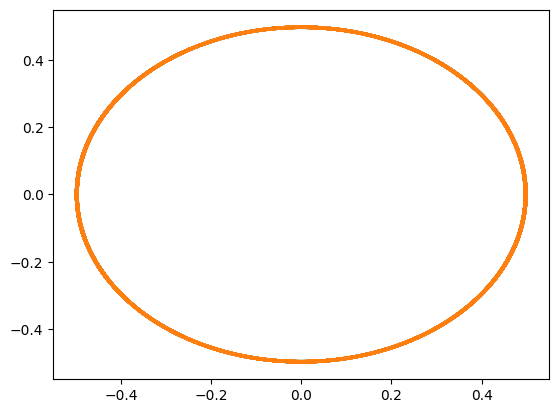

0.49999999995
0.4999942541407467


In [53]:

print(course_t[-2])

fig, ax = plt.subplots(1,1)
ax.plot(course_r[:-1,0,0],course_r[:-1,0,1])
ax.plot(course_r[:-1,1,0],course_r[:-1,1,1])
plt.show()
print(max(course_r[:,0,0]))
print(max(course_r[:,0,1]))

In [ ]:
text = 'time'
print("it's "+text)

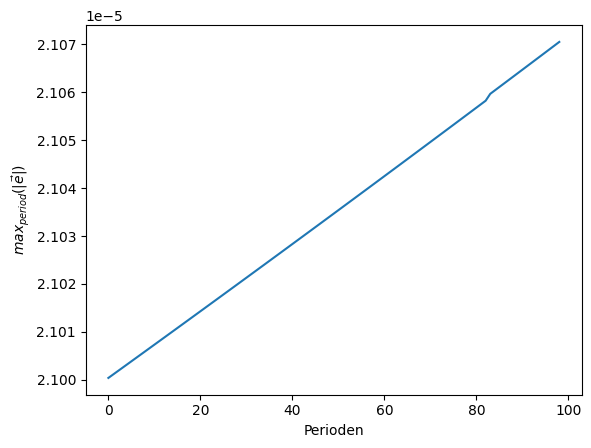

In [30]:
max_e = np.zeros(99)
for i in range(100-1):
    max_e[i] = np.max(c_rulenz[int(steps//block_size/100)*i:int(steps//block_size/100)*(i+1)])
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(99),max_e)
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$max_{period}(|\vec{e}|)$")
plt.show()

In [109]:
course_r = course_r[:p_100,:,:]
course_v = course_v[:p_100,:,:]
course_t = course_t[:p_100]
c_energy = c_energy[:p_100]
c_tot_angm = c_tot_angm[:p_100,:]
c_totm =c_totm[:p_100,:]
c_j = c_j[:p_100,:]
c_rulenz = c_rulenz[:p_100,:]
c_a_bha =c_a_bha[:p_100]

In [ ]:
import pandas as pd
data = pd.read_csv("2b_euler.txt",sep='\t')
print(data.head())
print(data[["c_rulenz[x]","c_rulenz[y]","c_rulenz[z]"]].head())
c_rulenz = data[["c_rulenz[x]","c_rulenz[y]","c_rulenz[z]"]].to_numpy()
course_t = data["course_t"].to_numpy()

hermite: j und a neg
iterated hermite : E neg

In [49]:
c_energy= np.zeros(course_r.shape[0])
for i in range(course_r.shape[0]):
    c_energy[i]=eng(course_r[i,:,:],course_v[i,:,:],0)

/var/folders/ch/3xykztb11m7_dgk_2xh5mvlc0000gp/T/ipykernel_1248/2803433496.py:8: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t[:20*period]/2/np.pi,np.log((e_abs-e_abs[5])/e_abs[5])[:20*period])
/var/folders/ch/3xykztb11m7_dgk_2xh5mvlc0000gp/T/ipykernel_1248/2803433496.py:8: RuntimeWarning: invalid value encountered in log
  ax.plot(course_t[:20*period]/2/np.pi,np.log((e_abs-e_abs[5])/e_abs[5])[:20*period])


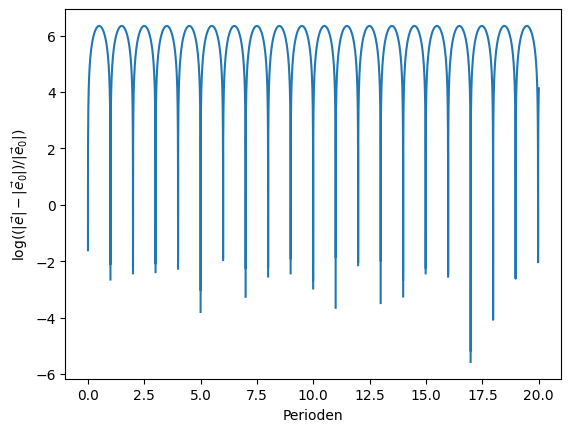

/var/folders/ch/3xykztb11m7_dgk_2xh5mvlc0000gp/T/ipykernel_1248/2803433496.py:15: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t/2/np.pi,np.log(-(j_abs-j_abs[0])/j_abs[0]))


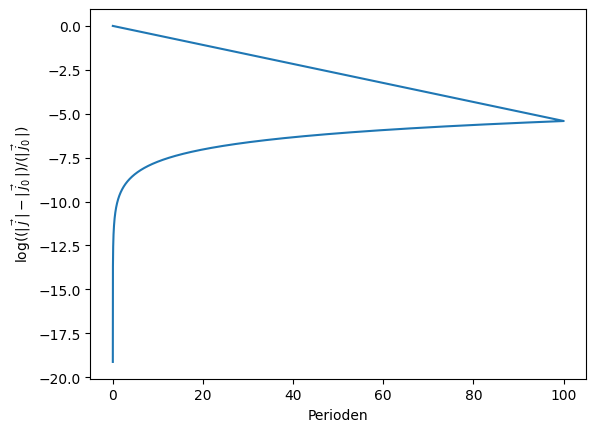

/var/folders/ch/3xykztb11m7_dgk_2xh5mvlc0000gp/T/ipykernel_1248/2803433496.py:23: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t/2/np.pi,np.log((c_energy-c_energy[0])/c_energy[0]))


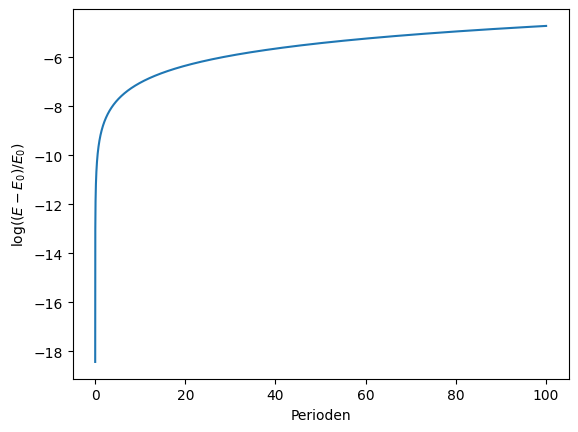

/var/folders/ch/3xykztb11m7_dgk_2xh5mvlc0000gp/T/ipykernel_1248/2803433496.py:30: RuntimeWarning: divide by zero encountered in log
  ax.plot(course_t/2/np.pi,np.log(-(c_a_bha-c_a_bha[0])/c_a_bha[0]))


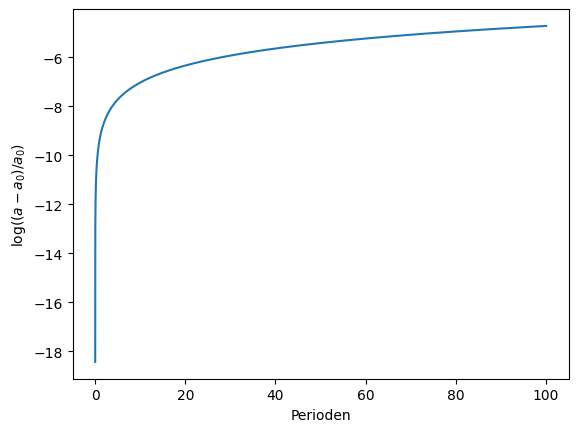

In [54]:
j_abs = np.sqrt(np.sum(c_j**2,axis=1))
e_abs = np.sqrt(np.sum(c_rulenz**2,axis=1))
fig, ax = plt.subplots(1,1)
save = "no"
it_name = "hermite_ct"
period = int(steps//block_size/100)
# ax.plot(course_t,np.sqrt(np.sum(c_j**2,axis=1)))
ax.plot(course_t[:20*period]/2/np.pi,np.log((e_abs-e_abs[5])/e_abs[5])[:20*period])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((|\vec{e}|-|\vec{e}_0|)/|\vec{e}_0|)$")
if save=="yes":
    plt.savefig(it_name+"_log_rulenz_20p.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,np.log(-(j_abs-j_abs[0])/j_abs[0]))
# ax.plot(course_t[:100000],np.sqrt(np.sum(c_rulenz**2,axis=1))[:100000])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((|\,\vec{j}\,|-|\,\vec{j}_0\,|)/(|\,\vec{j}_0\,|)$")
if save=="yes":
    plt.savefig(it_name+"_log_j.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,np.log((c_energy-c_energy[0])/c_energy[0]))
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((E-E_0)/E_0)$")
if save=="yes":
    plt.savefig(it_name+"_log_E.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,np.log(-(c_a_bha-c_a_bha[0])/c_a_bha[0]))
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$\log((a-a_0)/a_0)$")
if save=="yes":
    plt.savefig(it_name+"_log_a.png")
plt.show()


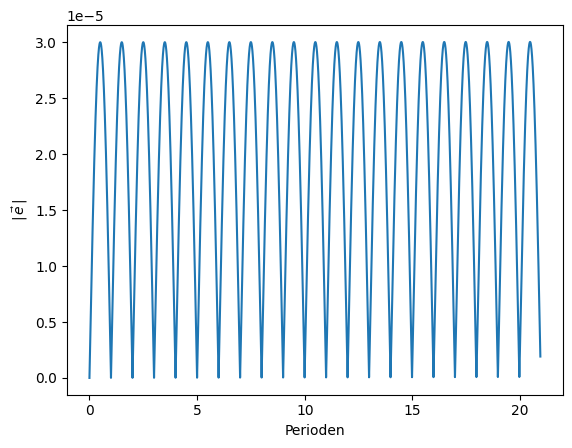

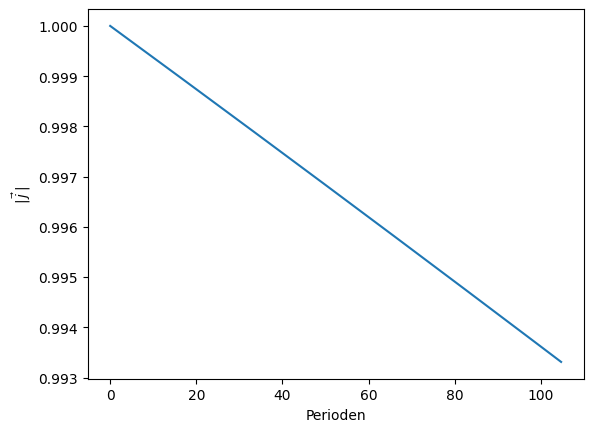

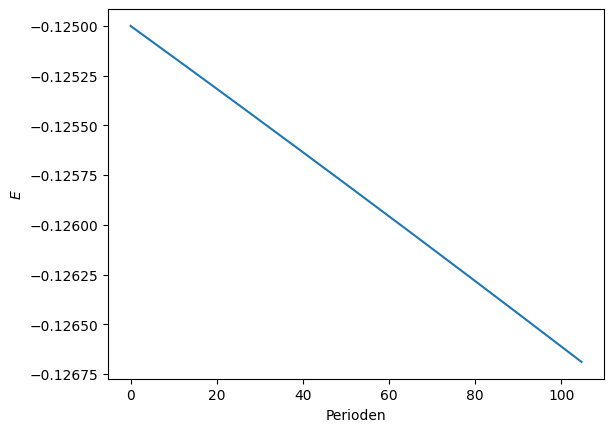

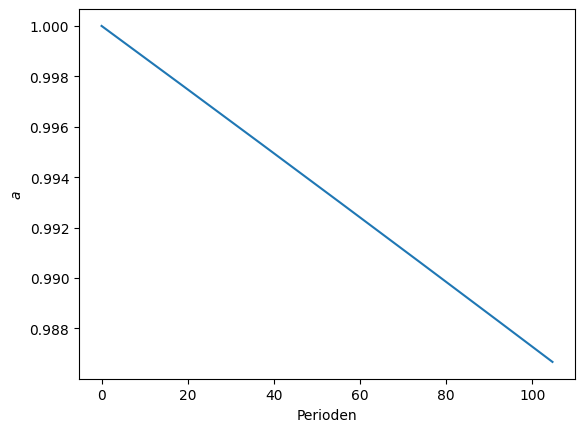

In [51]:
fig, ax = plt.subplots(1,1)
period = int(steps//block_size/100)
save = "no"
# ax.plot(course_t,np.sqrt(np.sum(c_j**2,axis=1)))
ax.plot(course_t[:20*period]/2/np.pi,e_abs[:20*period])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$|\,\vec{e}\,|$")
if save=="yes":
    plt.savefig(it_name+"_rulenz_20p.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,j_abs)
# ax.plot(course_t[:100000],np.sqrt(np.sum(c_rulenz**2,axis=1))[:100000])
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$|\,\vec{j}\,|$")
if save=="yes":
    plt.savefig(it_name+"_j.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,c_energy)
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$E$")
if save=="yes":
    plt.savefig(it_name+"_E.png")
plt.show()
fig, ax = plt.subplots(1,1)
ax.plot(course_t/2/np.pi,c_a_bha)
ax.set_xlabel("Perioden")
ax.set_ylabel(r"$a$")
if save=="yes":
    plt.savefig(it_name+"_a.png")
plt.show()

In [155]:
text = "something + "
print(text+"something else")

something + something else


(20000, 3)
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
[0.  0.  0.5]
62.000079999707495


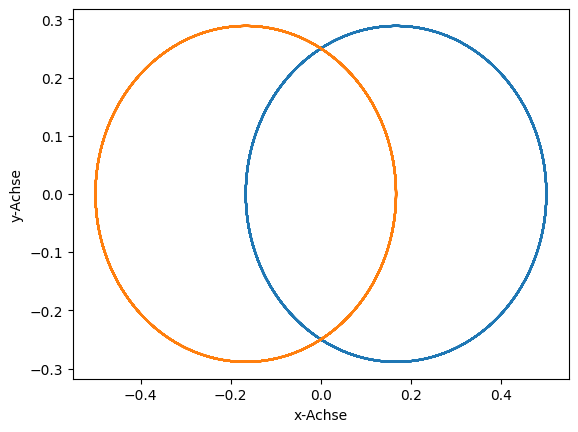

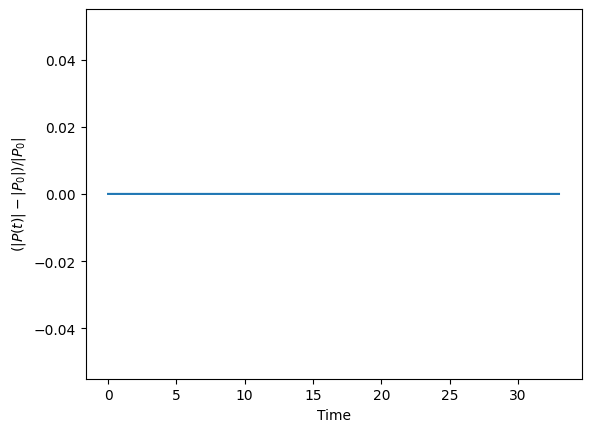

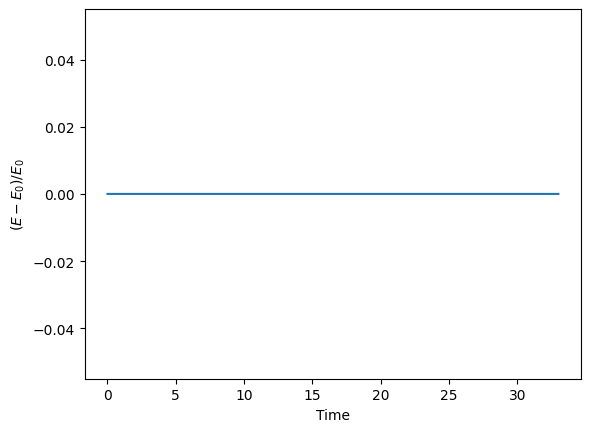

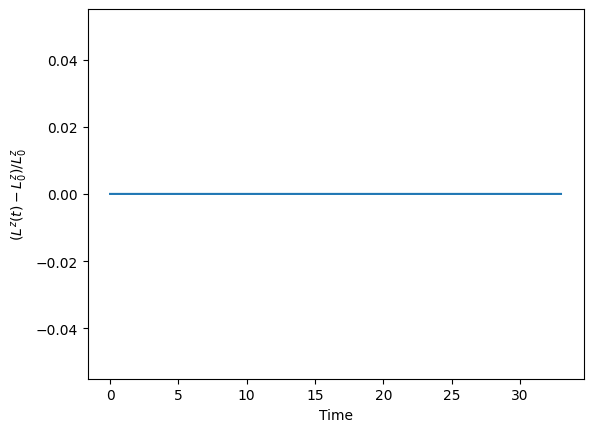

In [40]:
root = pathlib.Path.cwd()
paths =  root / 'e_data.txt', \
root / 'r_data.txt', \
root / 'v_data.txt', \
root / 't_data.txt', \
root / 'angmom_data.txt', \
root / 'mom_data.txt'


e_file = open(paths[0],'r')
r_file = open(paths[1],'r')
v_file = open(paths[2],'r')
t_file = open(paths[3],'r')
angmom_file = open(paths[4],'r')
mom_file = open(paths[5],'r')

course_r = np.loadtxt(r_file)
course_r =np.reshape(course_r,(300000//15,N,3))

course_v = np.loadtxt(v_file)
course_v =np.reshape(course_v,(300000//15,N,3))

c_energy = np.loadtxt(e_file)
c_tot_angm = np.loadtxt(angmom_file)
c_tot_angm = np.reshape(c_tot_angm,(300000//15,3))
c_totm = np.loadtxt(mom_file)
course_t = np.loadtxt(t_file)
e_file.close()
r_file.close()
v_file.close()
angmom_file.close()
mom_file.close()
t_file.close()


print(np.shape(c_tot_angm))
for i in range(20):
    print(c_tot_angm[i])
print(t_sum)
abs_momentum = np.linalg.norm(c_totm,axis=1) 
fig1, ax1 = plt.subplots(1,1)
for i in range(N):
    ax1.plot(course_r[:,i,0],course_r[:,i,1])
ax1.set_ylabel('y-Achse')
ax1.set_xlabel('x-Achse')
fig2, ax2 = plt.subplots(1,1)

ax2.plot(course_t,(abs_momentum-abs_momentum[0]))

ax2.set_xlabel('Time')
ax2.set_ylabel('$(|P(t)|-|P_0|)/|P_0|$')

fig3, ax3  = plt.subplots(1,1)

ax3.plot(course_t,(c_energy-c_energy[0])/c_energy[0])
ax3.set_ylabel('$(E-E_0)/E_0$')
ax3.set_xlabel('Time')
fig4 ,ax4 = plt.subplots(1,1)
ax4.plot(course_t,(c_tot_angm[:,2]-c_tot_angm[0,2])/c_tot_angm[0,2])
ax4.set_xlabel('Time')
ax4.set_ylabel('$(L^z(t)-L^z_0)/L^z_0$')


plt.show()

In [23]:
onefile = root / 'iteration_data.txt'

file = open(onefile,'w')

t_sum = 0
delta_t=t_delta
t_max = 62
r_iter= r_transformed
v_iter= v_transformed
steps = 60000
last_extract = 0
while kl(t_sum,t_max):
    
    t_sum= t_sum+delta_t
    if t_sum>(last_extract+t_delta*15):
        last_extract =t_sum
        file.write(f"\n{t_sum}")
    r_iter, v_iter, a_iter, dta_iter,rij_betrag = euler(r_iter,v_iter,delta_t)
    delta_t = time_delta(a_iter,dta_iter)
    if kl(delta_t,t_delta-0.3*t_delta)==True:
        delta_t=t_delta-0.3*t_delta
    elif kl(t_delta+10*t_delta,delta_t)==True:
        delta_t=t_delta+10*t_delta
    if t_sum>(last_extract+t_delta*15):
        last_extract =t_sum
        file.write(f', {eng(r_iter,v_iter,rij_betrag)}')
        for i in range(3):
            file.write(f', {total_angular_momentum(r_iter,v_iter)[i]}, {total_momentum(v_iter)[i]}')
        for n in range(N):
            for i in range(3):
                file.write(f', {r_iter[n,i]}, {v_iter[n,i]}')

file.close()
def energy_tot(pos,vel,betrag):
    v_sq= np.linalg.norm(vel,axis=2)
    T= np.dot(m[:,0],v_sq*v_sq)/2
    V= np.zeros(N)
    for n in range(N):
        norm = np.linalg.norm(pos-pos[:,n,:],axis=2)
        np.place(norm,norm==0,['inf'])
        V[n]= np.dot(m[:,0],m[n,0]*1/norm)/2
    V = sum(V)
    return T-V